# Asking salient questions

Now that we can generate the concept map, and calculate the cognitive load per sentence, let's display text blurbs in order of increasing cognitive load as we traverse the created learning path. Based on the blurbs, we will ask questions of the student that are multiple choice. The answers will be passed through a basic inference engine. 

The questions are designed to fill general schema for different entity types in the STEM domain. Relationships are defined based on the roles these entities play. A memory map will be simulated for the student, and review and follow-up questions will be asked based on the memory map for that student. 

Further work will be done for more intelligent question asking, and being able to prompt critical and creative thinking, through relationship extraction and entity detection models. Directing and/or exploring based on learning goals defined based on Bloom's taxonomy will also be done. 


In [1]:
import itertools
from itertools import chain
import nltk 
#stop_words = set(stopwords.words('english'))

#filename = 'A Mind For Numbers_ How to Excel at Math and Science (Even If You Flunked Algebra)'
filename = 'physics_iitjee_vol1'
concepts = {}
import pickle
# Loading extracted concepts from file (see concept_extraction.ipynb)
#concepts = {'sents':sents,'rawtxt':rawtxt,'sent_to_npflat':sent_to_npflat,'sent_to_tags':sent_to_tags,'sent_to_ltags':sent_to_ltags,'np_to_sent':np_to_sent,'Conceptdata':Conceptdata}
with open('../processed_data/'+filename +'concepts.pickle', 'rb') as f:
    concepts = pickle.load(f)

# Loading idf dictionary (see Build_IDF_dictionary.ipynb)
with open('../processed_data/'+'idf_dict.pickle','rb') as f1:
    idf_dict =pickle.load(f1)

with open('../processed_data/'+filename+'conceptimp.pickle','rb') as f2:
    dfConceptimp = pickle.load(f2)

sents = concepts['sents']
rawtxt = concepts['rawtxt']
sent_to_npflat = concepts['sent_to_npflat']
sent_to_tags= concepts['sent_to_tags']
sent_to_ltags = concepts['sent_to_ltags']
np_to_sent = concepts['np_to_sent']
Conceptdata = concepts['Conceptdata']

import math



def get_idf(wrd,totaldocs=10788):
    wrd = wrd.lower()
    return idf_dict.get(wrd,math.log(totaldocs))


In [2]:
import pandas as pd
with open('../processed_data/'+filename+'conceptmap.pickle','rb') as f2:
    df = pickle.load(f2)

In [3]:
def calc_cl_per_sentence(sent_to_npflatsent_to_npflat,known_concepts = [], maxidf=9.1):
    sent_to_clt = []
    for i in range(len(sent_to_npflat)):
        npinsent = sent_to_npflat[i]
        npinsent = [np for np in npinsent if np not in known_concepts]
        clt= 0
        for np in npinsent:
            tokens = np.split(' ')
            idf = 0
            for t in tokens:
                idf = idf + get_idf(t)
            idf = idf*len(tokens)*1.67
            if (idf>=maxidf):
                clt = clt + 1
        sent_to_clt.append(clt)
    return sent_to_clt

def plot_clt(sent_to_clt):
    
    from matplotlib import pyplot as plt
    plt.xlabel('document sentence #')
    plt.ylabel('Load added to working memory by sentence')
    plt.title('Cognitive Load for '+filename)
    plt.plot(list(range(1,len(sent_to_npflat)+1)),sent_to_clt,drawstyle='steps')
    plt.savefig('cltfig1.png')
    return None

sent_to_clt = calc_cl_per_sentence(sent_to_npflat)
plot_clt(sent_to_clt)

In [4]:
def print_sents_by_target_cl(target,cl):
    return [sents[s] for s in np_to_sent[target] if sent_to_clt[s]==cl]

print_sents_by_target_cl('life',1)

[]

In [5]:
sent_to_clt = calc_cl_per_sentence(sent_to_npflat)
print('Mininum cognitive load sentence: ',sents[sent_to_clt.index(min(sent_to_clt))])
print('Maximum cognitive load sentence: ',sents[sent_to_clt.index(max(sent_to_clt))])

Mininum cognitive load sentence:  1 of 4Dr.
Maximum cognitive load sentence:  81.1 Introduction1.1.1 Branches of Physics1.1.2 Scope and Excitement of Physics1.1.3 Physics in Relation to Technology and Society1.2   Measurement2.1   Different Types of Measurement Systems1.2.2 Measurement of Basic Quantities1.2.3 Parallax Method1.3   Theory of Errors1.3.1 Accuracy and Precision1.3.2 Errors in Measurement1.3.3 Error Analysis1.3.4 Propagation of Errors1.4    Significant Figures1.4.1 Definition and Rules of Significant Figures1.4.2 Rounding Off1.5   Dimensional Analysis1.5.1 Dimension of Physical Quantities1.5.2 Dimensional Formula and Equation1.5.3 Principle of Homogeneity of Dimensions1.6   Multiple Choice Questions with Detailed SolutionsChapter-2: Kinematics ​​….662.1 Introduction2.1.1 Concept of Rest and Motion2.1.2 Point mass2.2 Types of Motion2.3 Motion in One, Two and Three Dimensions2.4  Elementary Concepts of Vector Algebra2.4.1 Different Types of Vectors2.4.2 Addition of Vectors2.

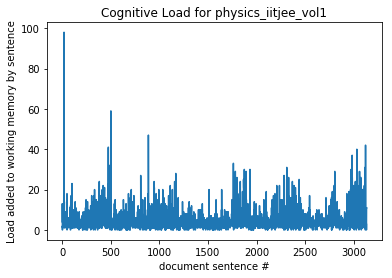

In [6]:
plot_clt(sent_to_clt)

Functions to get blurbs for two concepts


In [7]:
import pandas as pd
def calc_clt_blurb_order(tuplist):
    tup_to_clt = {}
    for tup in tuplist:
        blurb_clt = 0
        for i in range(tup[0],tup[1]+1):
            blurb_clt = blurb_clt + sent_to_clt[i]
        tup_to_clt[tup] = blurb_clt
    tup_to_clt = pd.Series(tup_to_clt)
    tup_to_clt.sort_values(ascending=True)
    return list(tup_to_clt.sort_values(ascending=True).index)
            
        

In [8]:
def get_sentence_indices(np1,np2,max_distance=3):
    sents1 = np_to_sent[np1]
    sents2 = np_to_sent[np2]
    ind1 = 0
    ind2 = 0
    tuplist = []
    lensents1 = len(sents1)
    #print(lensents1)
    lensents2 = len(sents2)
    #print(lensents2)
    while(ind1<lensents1 and ind2 <lensents2):
        #print(ind1,ind2)
        if (sents1[ind1]<sents2[ind2]):
            #print('sent1 less than sent2')
            if sents2[ind2]-sents1[ind1]<=max_distance:
                tuplist.append((sents1[ind1],sents2[ind2]))
                ind1 = ind1+1
                ind2 = ind2 + 1
            else:
                #ind1 = bs.bisect_left(sents1,sents2[ind2])
                ind1 = ind1 + 1
        elif (sents1[ind1]>sents2[ind2]):
            #print('sent2 less than sent1')
            if sents1[ind1]-sents2[ind2] <= max_distance:
                tuplist.append((sents2[ind2],sents1[ind1]))
                ind1 = ind1 + 1
                ind2 = ind2 + 1
            else:
                #ind2 = bs.bisect_left(sents2,sents1[ind1])
                ind2 = ind2 + 1
        else:
            tuplist.append((sents1[ind1],sents2[ind2]))
            ind1 = ind1+1
            ind2 = ind2+1
    return tuplist

def get_blurbs(np1,np2,max_distance=3):
    blurblist = []
    tuplist = calc_clt_blurb_order(get_sentence_indices(np1,np2,max_distance))
    print(tuplist)
    for t in tuplist:
        blurb = []
        print(t)
        blurb = ' '.join(sents[t[0]:t[1]+1]).replace('\n', ' ').replace('\r', '')
        print(blurb)
        blurblist.append(blurb)
    return tuplist, blurblist

In [9]:
tuplist, blurblist = get_blurbs('speed','velocity',0)

[(860, 860), (1669, 1669), (737, 737), (2443, 2443), (687, 687), (668, 668), (671, 671), (919, 919), (667, 667), (646, 646), (2257, 2257), (934, 934), (1848, 1848), (682, 682), (2368, 2368), (1789, 1789), (808, 808), (887, 887)]
(860, 860)
In uniform circular motion, the velocity is always changing but speed remains the same.
(1669, 1669)
Both the direction and magnitude (speed) of velocity can be changed.
(737, 737)
Calculate the swimmer’s speed in still water and the velocity of the river flow.Solution: Let vs and vr , represent the velocities of the swimmer and river respectively with respect to ground.
(2443, 2443)
Then after all collision A and B are brought to rest  and C takes off with velocity of...... (elastic collision)(A) 20 m/s              (B) 2.5 m/s(C) 10 m/s              (D) 7.5 m/s [image file=rsrcET7.jpg] Solution:     A hits B head on with speed 10 m/s.
(687, 687)
Hence, [image file=rsrcE68.jpg] The particle C has the greatest speed.Example 2.23: Two cars are travell

In [10]:
import networkx as nx
import numpy as num

In [11]:
bond_threshold=num.quantile(df['Bondstrength'],0.0)
dfdir = df[(df['Direction']>=1) & (df['Bondstrength']>=bond_threshold)]
print(len(dfdir))

40848


0.3333333333333333
Including the following concepts : ['particle', 'mass', 'velocity', 'body', 'force']
The nodes that connect these concepts:  ['velocity', 'body', 'mass', 'particle', 'force']
{'velocity', 'particle', 'body', 'force'}
{'body', 'velocity', 'mass'}
Roots:  {'particle', 'force'}
Leaves: {'mass'}
All the longest paths in this subgraph:
['particle', 'velocity', 'mass']
['force', 'body', 'mass']


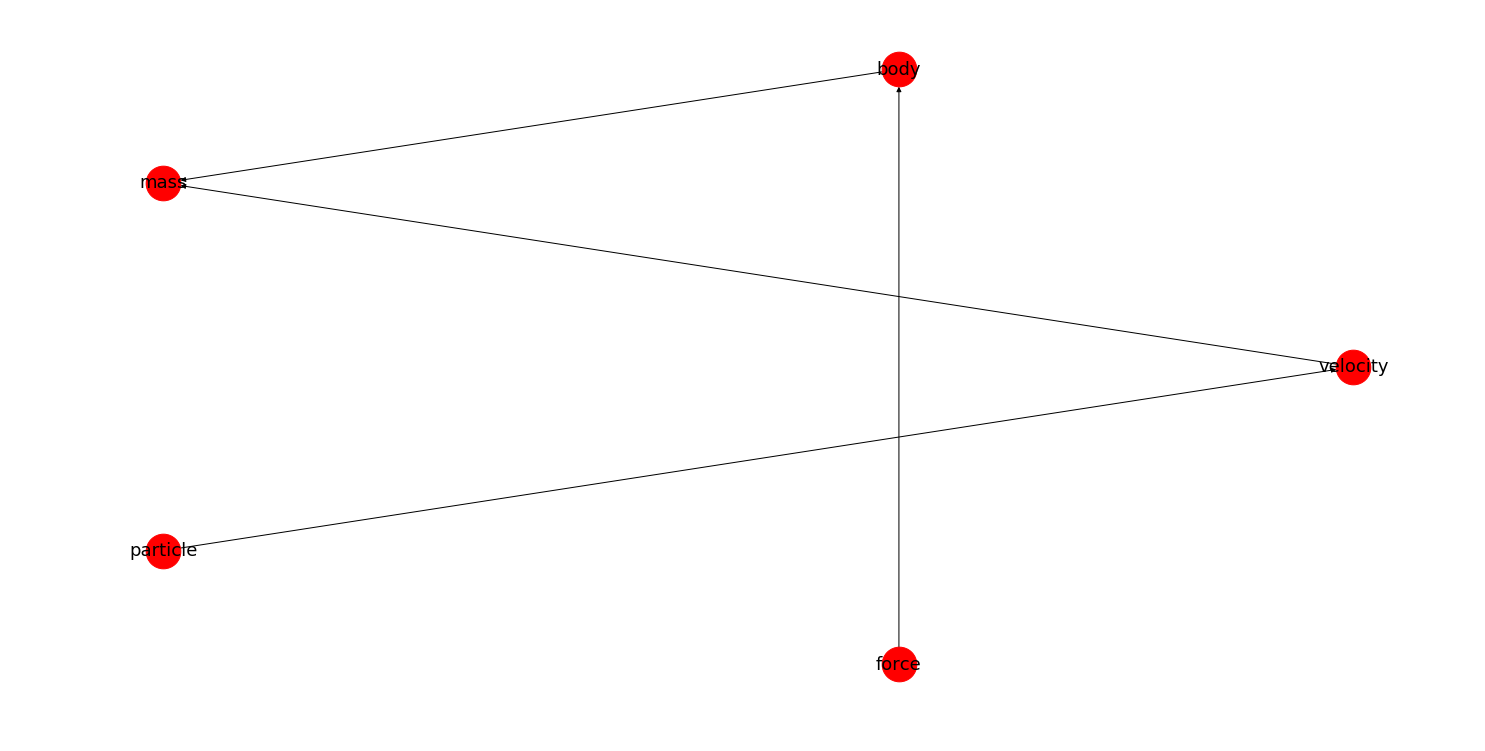

In [12]:
print(bond_threshold)
import networkx as nx
import matplotlib.pyplot as plt
G = nx.from_pandas_edgelist(dfdir,'Concept1','Concept2', create_using=nx.DiGraph())


paths=dict(nx.all_pairs_shortest_path(G,cutoff=None))
def get_nodes_allpairs(concept_list):
    nodelist = [paths.get(cl1, {}).get(cl2,None) for cl1 in concept_list for cl2 in concept_list if paths.get(cl1, {}).get(cl2,None) is not None]
    nodelist = list(chain.from_iterable(nodelist))
    return list(set(nodelist))

start_concepts_number = 5   # Start drawing graph with top n concepts

start_concept_list = list(dfConceptimp.sort_values(by=['TFIDFA','Amap','SdevA','AfirstOc'],ascending=[False,False,False,True]).head(start_concepts_number)['Concept1'])

print('Including the following concepts :',start_concept_list)

# now get the paths from all pairs in the concept list and the corresponding nodes 
nodelist = get_nodes_allpairs(start_concept_list)
print('The nodes that connect these concepts: ', nodelist)
start_concept_edges = dfdir[dfdir['Concept1'].isin(nodelist) & dfdir['Concept2'].isin(nodelist)]
start_concept_from = set(start_concept_edges['Concept1'])
print(start_concept_from)
start_concept_to = set(start_concept_edges['Concept2'])
print(start_concept_to)
roots = start_concept_from - start_concept_to
print('Roots: ',roots)

leaves = start_concept_to - start_concept_from
print('Leaves:',leaves)
print('All the longest paths in this subgraph:')
for r in roots:
    for l in leaves:
        if nx.has_path(G,r,l):
            print(paths[r][l])

len(start_concept_edges)
plt.figure(figsize=(20,10))
nx.draw_circular(G.subgraph(list(start_concept_from | start_concept_to)),with_labels=True, font_size=18,node_size=1200)

In [13]:
def in_and_out_nodes(G,concept):
    return list(G.predecessors(concept)) + list(G.successors(concept)) + [concept]
    
def draw_graph(G,nodes_list):
    plt.figure(figsize=(20,10))
    nx.draw_circular(G.subgraph(nodes_list),with_labels=True, font_size=18,node_size=1200)
    
def 

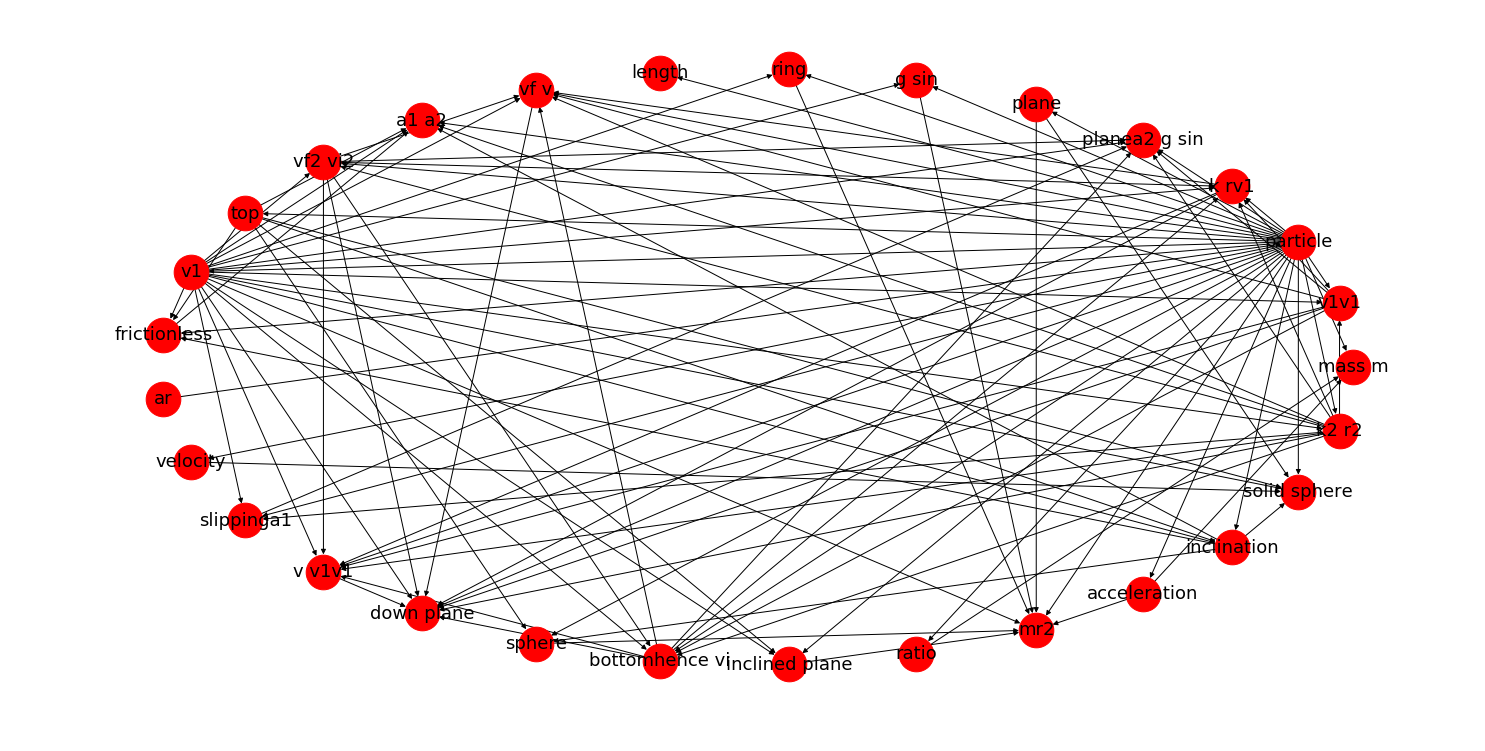

In [14]:
draw_graph(G,in_and_out_nodes(G,'particle'))

In [27]:
get_blurbs('speed','classical mechanic',10)


[(77, 82), (81, 84), (92, 98), (29, 33), (1, 9), (0, 7), (85, 92), (12, 22), (87, 97)]
(77, 82)
Classical mechanics also describes the more complex motions of extended non-pointlike objects. Euler's laws provide extensions to Newton's laws in this area. The concepts of angular momentum rely on the same calculus used to describe one-dimensional motion. The rocket equation extends the notion of rate of change of an object's momentum to include the effects of an object "losing mass". There are two important alternative formulations of classical mechanics: Lagrangian mechanics and Hamiltonian mechanics. These, and other modern formulations, usually bypass the concept of "force", instead referring to other physical quantities, such as energy, speed and momentum, for describing mechanical systems in generalized coordinates.
(81, 84)
There are two important alternative formulations of classical mechanics: Lagrangian mechanics and Hamiltonian mechanics. These, and other modern formulations, us

([(77, 82),
  (81, 84),
  (92, 98),
  (29, 33),
  (1, 9),
  (0, 7),
  (85, 92),
  (12, 22),
  (87, 97)],
 ['Classical mechanics also describes the more complex motions of extended non-pointlike objects. Euler\'s laws provide extensions to Newton\'s laws in this area. The concepts of angular momentum rely on the same calculus used to describe one-dimensional motion. The rocket equation extends the notion of rate of change of an object\'s momentum to include the effects of an object "losing mass". There are two important alternative formulations of classical mechanics: Lagrangian mechanics and Hamiltonian mechanics. These, and other modern formulations, usually bypass the concept of "force", instead referring to other physical quantities, such as energy, speed and momentum, for describing mechanical systems in generalized coordinates.',
  'There are two important alternative formulations of classical mechanics: Lagrangian mechanics and Hamiltonian mechanics. These, and other modern formu

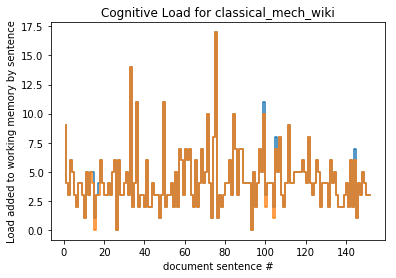

In [28]:
plot_clt(calc_cl_per_sentence(sent_to_npflat))
known_concepts = ['geometry','orbitals','electron','atom','element','parameter','program','nucleus']
plot_clt(calc_cl_per_sentence(sent_to_npflat,known_concepts))

In [29]:
print_sents_by_target_cl('life',2)

KeyError: 'life'

In [30]:
df[(df['Concept1']=='surface') & (df['Direction']>=1)].sort_values(by=['Bondstrength','dAB_dBA_diff'],ascending=[False, False]).head(41)

,Concept1,Concept2,FA,FB,SdevA,SdevB,Bondstrength,meanBSA,meanBSB,dAB,...,TFA,TFB,TFIDFA,TFIDFB,Bondstrengthdiff,min_dAB_dBA,AminusB_BminusA_diff,dAB_dBA_diff,IDFB_IDFA_diff,Direction


In [19]:
print_sents_by_target_cl('monte carlo method',5)

KeyError: 'monte carlo method'

In [20]:
print_sents_by_target_cl('functional',2)

[]

In [21]:
sents[1275:1279]

['Researchers have found that procrastination can even become a source of pride as well as an excuse for doing poorly.',
 '“I crammed for the quiz last night after finishing the lab report and the marketing interview.',
 'Of course I could have done better.',
 'But with so many things on my plate, what do you expect?']

In [22]:
tuplist,blurblist = get_blurbs('life','woman',3)

[(1349, 1351)]
(1349, 1351)
”{ 6 }zombies everywhere:Digging Deeper to Understand the Habit of ProcrastinationIn the insightful book The Power of Habit, author Charles Duhigg describes a lost soul—Lisa Allen, a middle-aged woman who had always struggled with her weight, who had begun drinking and smoking when she was sixteen, and whose husband had left her for another woman. Lisa had never held a job for more than a year and had fallen deeply into debt. But in a four-year span, Lisa turned her life around completely.


In [23]:
print([sents[i] for i in np_to_sent['pes']])

KeyError: 'pes'

In [31]:
fromset = set(dfdir['Concept1'])
toset = set(dfdir['Concept2'])
rootset = fromset-toset
leavesset = toset-fromset

In [32]:
df[df['Concept2'].isin(list(leavesset))].sort_values(by='FB',ascending=False).head(30)

,Concept1,Concept2,FA,FB,SdevA,SdevB,Bondstrength,meanBSA,meanBSB,dAB,...,TFA,TFB,TFIDFA,TFIDFB,Bondstrengthdiff,min_dAB_dBA,AminusB_BminusA_diff,dAB_dBA_diff,IDFB_IDFA_diff,Direction
9,galaxy,present state,1,1,0.0,0.0,0.500000,0.812500,0.593750,1.0,...,0.006579,0.006579,0.053866,0.020450,-0.312500,1.0,0,0.0,-5.079117,True
4908,wavelength,failure,2,1,1.0,0.0,0.333333,0.613636,0.807692,3.0,...,0.013158,0.006579,0.122187,0.031134,-0.474359,2.0,9,1.0,-4.553877,True
5056,clinton davisson,failure,1,1,0.0,0.0,0.333333,0.613636,0.807692,2.0,...,0.006579,0.006579,0.054253,0.031134,-0.474359,2.0,9,0.0,-3.514156,True
5039,clinton davisson,face,1,1,0.0,0.0,1.000000,0.613636,0.613636,0.0,...,0.006579,0.006579,0.054253,0.027956,0.386364,0.0,0,0.0,-3.997232,True
5034,lester germer,failure,1,1,0.0,0.0,0.333333,0.613636,0.807692,2.0,...,0.006579,0.006579,0.061093,0.031134,-0.474359,2.0,9,0.0,-4.553877,True
5017,lester germer,face,1,1,0.0,0.0,1.000000,0.613636,0.613636,0.0,...,0.006579,0.006579,0.061093,0.027956,0.386364,0.0,0,0.0,-5.036953,True
5012,face,failure,1,1,0.0,0.0,0.333333,0.613636,0.807692,2.0,...,0.006579,0.006579,0.027956,0.031134,-0.474359,2.0,9,0.0,0.483076,False
4990,single diffraction side lobe,failure,1,1,0.0,0.0,0.333333,0.613636,0.807692,2.0,...,0.006579,0.006579,0.045949,0.031134,-0.474359,2.0,9,0.0,-2.251893,True
4972,single diffraction side lobe,face,1,1,0.0,0.0,1.000000,0.613636,0.613636,0.0,...,0.006579,0.006579,0.045949,0.027956,0.386364,0.0,0,0.0,-2.734968,True
4968,atomic spacing,failure,1,1,0.0,0.0,0.333333,0.613636,0.807692,2.0,...,0.006579,0.006579,0.058813,0.031134,-0.474359,2.0,9,0.0,-4.207303,True
